In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle
# Import for processing video
from moviepy.editor import VideoFileClip
from IPython.display import HTML



Camera Calibration

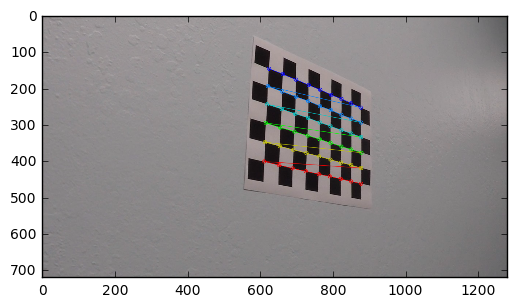

In [2]:
nx = 9 # Number of inside corners
ny = 6 # Number of inside corners

# Reading a list of calibration images

# glob allows us to read in files with consistent file names

calibration_images = glob.glob("camera_cal/calibration*.jpg")

# Initialise image and object point arrays
objpoints = []
imgpoints = []

# Generate object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates


# Iterate through images for their points
for image in calibration_images:
    img = cv2.imread(image)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

# Returns camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

# Save camera calibration result for later use 
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_calibration_result.p", "wb" ) )

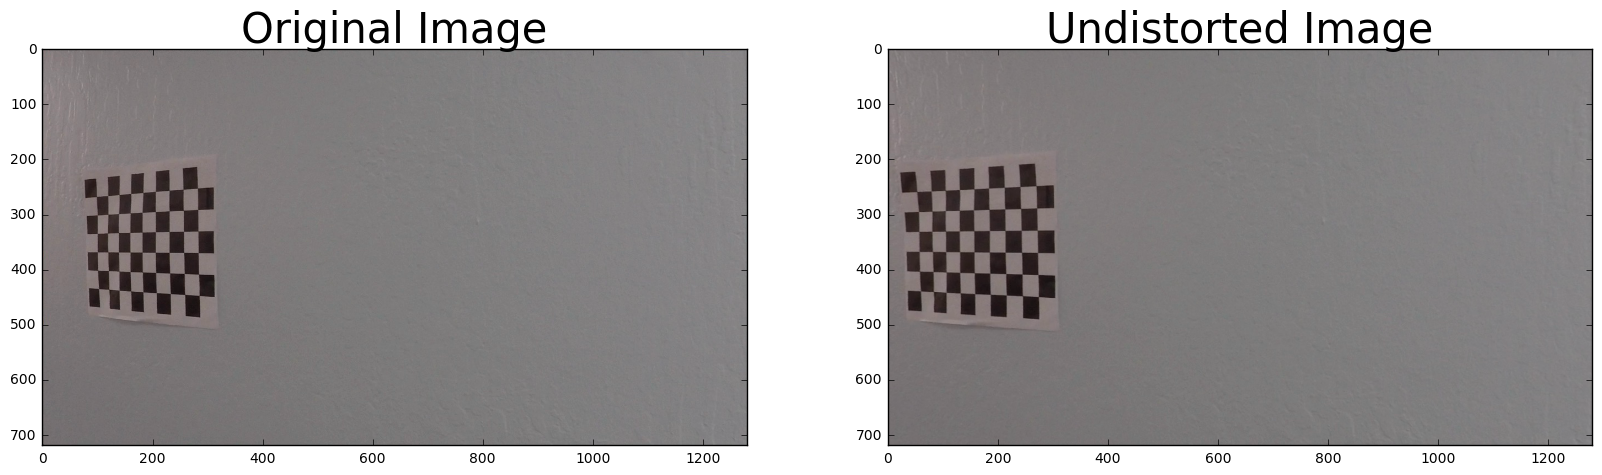

In [3]:
# Testing on an image
img = cv2.imread('camera_cal/calibration11.jpg')
img_size = (img.shape[1], img.shape[0])

with open('camera_calibration_result.p', 'rb') as f:
        dist_pickle = pickle.load(f)
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

#Undistorting a test image
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)


# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
cv2.imwrite('output_images/camera_calibration_original_Image.png',img)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
cv2.imwrite('output_images/camera_calibration_undistorted_Image.png',dst)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Image Pipeline


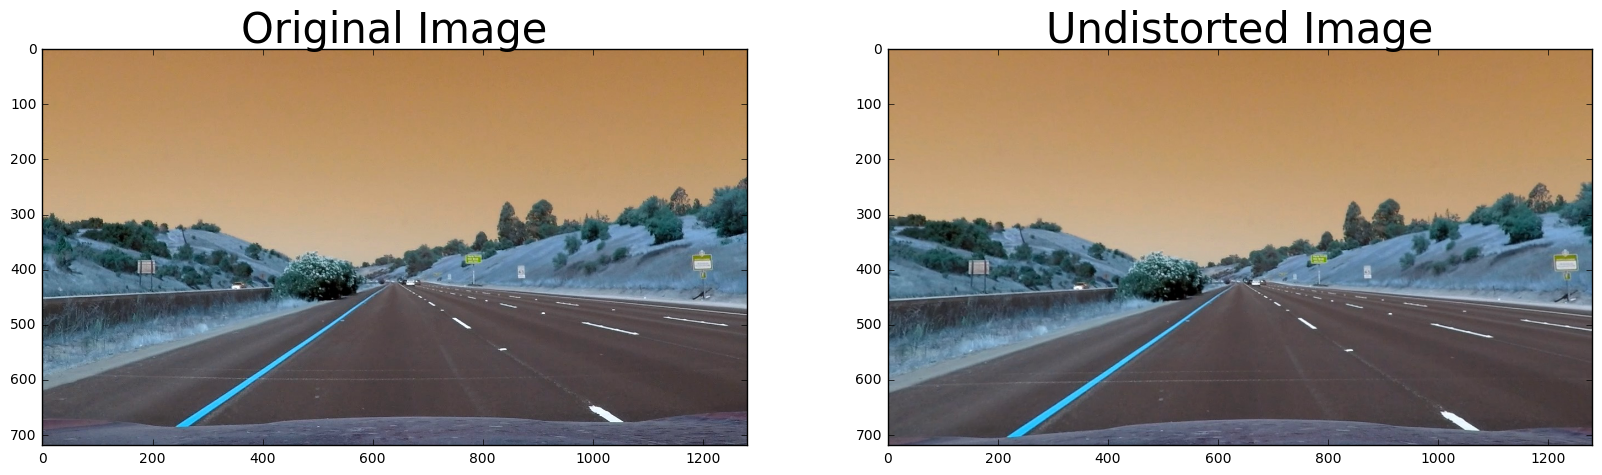

In [4]:
#contrasting raw and undistorted images
raw = cv2.imread("test_images/straight_lines1.jpg")

image = cv2.undistort(raw, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
cv2.imwrite('output_images/Original_Image.png',raw)
ax1.imshow(raw)
ax1.set_title('Original Image', fontsize=30)
cv2.imwrite('output_images/Undistorted_Image.png',raw)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=30)

#Online resources used
# https://github.com/mvirgo/Advanced-Lane-Lines
# https://en.wikipedia.org/wiki/Radius_of_curvature
# https://chatbotslife.com/robust-lane-finding-using-advanced-computer-vision-techniques-46875bb3c8aa#.j3ltsanzx

In [5]:
''' Tried different thresholds for S channel and R'''
def combined_binary(img, s_thresh=(125, 255), sx_thresh=(10, 100), R_thresh = (200, 255), sobel_kernel = 3):
    """This version uses thresholds on the R & S color channels and Sobelx.
    Binary activation occurs where any two of the three are activated.
    """
    distorted_img = np.copy(img)
    dst = cv2.undistort(distorted_img, mtx, dist, None, mtx)
    # R Channel
    R = dst[:,:,0]
    #Saving R image
   # cv2.imwrite('output_images/R_Channel_Image.png',R)
    
    # Converting to HLS colorspace
    hls = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    #Saving S Channel image
  #  cv2.imwrite('output_images/S_Channel_Image.png',s_channel)
    
    # Sobelx - takes the derivate in x and then rescale
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1

    # Threshold R color channel
    R_binary = np.zeros_like(R)
    R_binary[(R >= R_thresh[0]) & (R <= R_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Activate the binary image even if two of three are good
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) & (sxbinary == 1)) | ((sxbinary == 1) & (R_binary == 1))
                     | ((s_binary == 1) & (R_binary == 1))] = 1
       
    
    
    return combined_binary

In [6]:
""" Birds eye function invokes combined binary function, then undistorts the image using defined source image points and destination points,
    finally returns the birds eye image and transform matrix.
        """

def birds_eye(img, mtx, dist):
     # Put the image through the pipeline to get the binary image
    binary_img = combined_binary(img)
    
    # Undistort
    undist = cv2.undistort(binary_img, mtx, dist, None, mtx)
    
   

    # Grab the image shape
    img_size = (undist.shape[1], undist.shape[0])

    # Source points - defined area of lane line edges
    src = np.float32([[690,450],[1110,img_size[1]],[175,img_size[1]],[595,450]])

    # 4 destination points to transfer
    offset = 300 # offset for dst points
    dst = np.float32([[img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]],
                      [offset, img_size[1]],[offset, 0]])
    
    # Use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Use cv2.warpPerspective() to warp the image to a top-down view
    top_down = cv2.warpPerspective(undist, M, img_size)
    
    

    return top_down,M


In [7]:
#using the Left Line class structure as defined in the example code in lesson
class Left_Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # recent polynomial coefficients
        self.recent_fit = []
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        # counter to reset after 5 iterations if issues arise
        self.counter = 0
        
#using the Right Line class structure as defined in the example code in lesson       
class Right_Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # recent polynomial coefficients
        self.recent_fit = []
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        # counter to reset after 5 iterations if issues arise
        self.counter = 0

In [8]:
def count_check(line):
    """ Resets to using new sliding windows below if
    upon failing five times in a row.
    """
    if line.counter >= 5:
        line.detected = False

def first_lines(img, mtx, dist):
    """ First Lines uses the birds eye image from above,
    creates a histogram of where the binary activations occur,
    and uses sliding windows along the peak areas to estimate
    where the lane lines are.
    """
    # Load the birds eye image and transform matrix from birds_eye
    binary_warped, perspective_M = birds_eye(img, mtx, dist)
    
    # Histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    #plt.plot(histogram)
    
    # Output image an to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
   # cv2.imwrite('output_images/output_binary_warped_Image.png',out_img)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each lane
    n = 5
    left_line.current_fit = np.polyfit(lefty, leftx, 2)
    left_line.all_x = leftx
    left_line.all_y = lefty
    left_line.recent_fit.append(left_line.current_fit)
    if len(left_line.recent_fit) > 1:
        left_line.diffs = (left_line.recent_fit[-2] - left_line.recent_fit[-1]) / left_line.recent_fit[-2]
    left_line.recent_fit = left_line.recent_fit[-n:]
    left_line.best_fit = np.mean(left_line.recent_fit, axis = 0)
    left_fit = left_line.current_fit
    left_line.detected = True
    left_line.counter = 0
    

    # Next, right line    
   
    n = 5
    right_line.current_fit = np.polyfit(righty, rightx, 2)
    right_line.all_x = rightx
    right_line.all_y = righty
    right_line.recent_fit.append(right_line.current_fit)
    if len(right_line.recent_fit) > 1:
        right_line.diffs = (right_line.recent_fit[-2] - right_line.recent_fit[-1]) / right_line.recent_fit[-2]
    right_line.recent_fit = right_line.recent_fit[-n:]
    right_line.best_fit = np.mean(right_line.recent_fit, axis = 0)
    right_fit = right_line.current_fit
    right_line.detected = True
    right_line.counter = 0
    
      
def second_ord_poly(line, val):
    """ Simple function being used to help calculate distance from center.
    Only used within Draw Lines below. Finds the base of the line at the
    bottom of the image.
    """
    a = line[0]
    b = line[1]
    c = line[2]
    formula = (a*val**2)+(b*val)+c

    return formula

def draw_lines(img, mtx, dist):
    """ Draw Lines will first check whether the lines are detected.
    If not, go back up to First Lines. If they are, we do not have to search
    the whole image for the lines. We can then draw the lines,
    as well as detect where the car is in relation to the middle of the lane,
    and what type of curvature it is driving at.
    """
    # Pull in the image
    binary_warped, perspective_M = birds_eye(img, mtx, dist)
    #plt.plot(binary_warped)
    
   # plt.plot(perspective_M)

    # Check if lines were last detected; if not, re-run first_lines
    if left_line.detected == False | right_line.detected == False:
        first_lines(img, mtx, dist)

    # Set the fit as the current fit for now
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit

    # Again, find the lane indicators
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Set the x and y values of points on each line
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each again.
    # Similar to first_lines, need to try in case of errors
    # Left line first
    n = 5
    left_line.current_fit = np.polyfit(lefty, leftx, 2)
    left_line.all_x = leftx
    left_line.all_y = lefty
    left_line.recent_fit.append(left_line.current_fit)
    if len(left_line.recent_fit) > 1:
        left_line.diffs = (left_line.recent_fit[-2] - left_line.recent_fit[-1]) / left_line.recent_fit[-2]
    left_line.recent_fit = left_line.recent_fit[-n:]
    left_line.best_fit = np.mean(left_line.recent_fit, axis = 0)
    left_fit = left_line.current_fit
    left_line.detected = True
    left_line.counter = 0
   
    # right line    
    
    n = 5
    right_line.current_fit = np.polyfit(righty, rightx, 2)
    right_line.all_x = rightx
    right_line.all_y = righty
    right_line.recent_fit.append(right_line.current_fit)
    if len(right_line.recent_fit) > 1:
        right_line.diffs = (right_line.recent_fit[-2] - right_line.recent_fit[-1]) / right_line.recent_fit[-2]
    right_line.recent_fit = right_line.recent_fit[-n:]
    right_line.best_fit = np.mean(right_line.recent_fit, axis = 0)
    right_fit = right_line.current_fit
    right_line.detected = True
    right_line.counter = 0
    
    # Generate x and y values for plotting
    fity = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([fit_leftx-margin, fity]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_leftx+margin, fity])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([fit_rightx-margin, fity]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_rightx+margin, fity])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Calculate the pixel curve radius
    y_eval = np.max(fity)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(left_line.all_y*ym_per_pix, left_line.all_x*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_line.all_y*ym_per_pix, right_line.all_x*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    avg_rad = round(np.mean([left_curverad, right_curverad]),0)
    rad_text = "Radius of Curvature = {}(m)".format(avg_rad)

    # Calculating middle of the image, aka where the car camera is
    middle_of_image = img.shape[1] / 2
    car_position = middle_of_image * xm_per_pix

    # Calculating middle of the lane
    left_line_base = second_ord_poly(left_fit_cr, img.shape[0] * ym_per_pix)
    right_line_base = second_ord_poly(right_fit_cr, img.shape[0] * ym_per_pix)
    lane_mid = (left_line_base+right_line_base)/2

    # Calculate distance from center and list differently based on left or right
    dist_from_center = lane_mid - car_position
    if dist_from_center >= 0:
        center_text = "{} meters to left".format(round(dist_from_center,2))
    else:
        center_text = "{} meters to right".format(round(-dist_from_center,2))
        
    # List car's position in relation to middle on the image and radius of curvature
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, center_text, (10,50), font, 1,(255,255,255),2)
    cv2.putText(img, rad_text, (10,100), font, 1,(255,255,255),2)

    # Invert the transform matrix from birds_eye (to later make the image back to normal below)
    Minv = np.linalg.inv(perspective_M)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([fit_leftx, fity]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, fity])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    return result


In [9]:
def process_image(image):
    """ This processes through everything above.
    Will return the image with car position, lane curvature, and lane lines drawn.
    """
    result = draw_lines(image, mtx, dist)
    
    return result

# Convert to video
# vid_output is where the image will be saved to

left_line = Left_Line()
right_line = Right_Line()
'''
testimg = cv2.imread('test_images/straight_lines1.jpg')
process_image(testimg)
'''


vid_output = 'video_output.mp4'

# The file referenced in clip1 is the original video before anything has been done to it
clip1 = VideoFileClip("project_video.mp4")

# NOTE: this function expects color images
vid_clip = clip1.fl_image(process_image) 
vid_clip.write_videofile(vid_output, audio=False)



[MoviePy] >>>> Building video video_output.mp4
[MoviePy] Writing video video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:08<00:00,  3.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output.mp4 

